Link to the Recorded Video: https://uchicago.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=4ae7bc98-2836-4bd8-a494-b0370016fed3

# Versioning using DeltaLake

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Delta Lake and Spark configuration

In [6]:
!pip install delta-spark -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=853018ad032809e6b05c036045183370febd61039fab473b5612462a2f2a1789
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [7]:
import pandas as pd
import numpy as np
from delta import *
import pyspark
builder = pyspark.sql.SparkSession.builder.appName("MyApp") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

## Delta Lake Trial Code

In [4]:
data = spark.range(0, 5)
data.write.format("delta").save("/content/drive/MyDrive/DeltaTable/trial_delta-2")

In [7]:
df = spark.read.format("delta").load("/content/drive/MyDrive/DeltaTable/trial_delta-2")
df.show()

+---+
| id|
+---+
|  2|
|  3|
|  4|
|  0|
|  1|
+---+



In [19]:
data = spark.range(5, 10)
data.write.format("delta").mode("overwrite").save("/content/drive/MyDrive/DeltaTable/trial_delta")

In [6]:
df = spark.read.format("delta").load("/content/drive/MyDrive/DeltaTable/trial_delta")
df.show()

+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
| 10|
| 11|
| 12|
| 13|
| 14|
| 15|
| 16|
| 17|
| 18|
| 19|
+---+



### Conditional update without overwrite
Delta Lake provides programmatic APIs to conditional update, delete, and merge (upsert) data into tables. Here are a few examples:

In [21]:
from delta.tables import *
from pyspark.sql.functions import *

deltaTable = DeltaTable.forPath(spark, "/content/drive/MyDrive/DeltaTable/trial_delta")

# Update every even value by adding 100 to it
deltaTable.update(
  condition = expr("id % 2 == 0"),
  set = { "id": expr("id + 100") })

# Delete every even value
deltaTable.delete(condition = expr("id % 2 == 0"))

# Upsert (merge) new data
newData = spark.range(0, 20)

deltaTable.alias("oldData") \
  .merge(
    newData.alias("newData"),
    "oldData.id = newData.id") \
  .whenMatchedUpdate(set = { "id": col("newData.id") }) \
  .whenNotMatchedInsert(values = { "id": col("newData.id") }) \
  .execute()

deltaTable.toDF().show()

+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
| 10|
| 11|
| 12|
| 13|
| 14|
| 15|
| 16|
| 17|
| 18|
| 19|
+---+



In [22]:
df = spark.read.format("delta") \
  .option("versionAsOf", 0) \
  .load("/content/drive/MyDrive/DeltaTable/trial_delta")

df.show()

+---+
| id|
+---+
|  2|
|  3|
|  4|
|  0|
|  1|
+---+



In [23]:
df = spark.read.format("delta") \
  .option("versionAsOf", 1) \
  .load("/content/drive/MyDrive/DeltaTable/trial_delta")

df.show()

+---+
| id|
+---+
|  7|
|  8|
|  9|
|  5|
|  6|
+---+



In [24]:
df = spark.read.format("delta") \
  .option("versionAsOf", 2) \
  .load("/content/drive/MyDrive/DeltaTable/trial_delta")

df.show()

+---+
| id|
+---+
|  7|
|108|
|  9|
|  5|
|106|
+---+



In [25]:
df = spark.read.format("delta") \
  .option("versionAsOf", 3) \
  .load("/content/drive/MyDrive/DeltaTable/trial_delta")

df.show()

+---+
| id|
+---+
|  7|
|  9|
|  5|
+---+



## Start of the assignment 1

### Delta Lake and Spark configuration

In [2]:
import pandas as pd
import numpy as np
from delta import *
import pyspark
builder = pyspark.sql.SparkSession.builder.appName("MyApp") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

### Read the data

In [8]:
df = spark.read \
    .option("multiline", True)\
    .option("quote", "\"")  \
    .option("escape", "\"") \
    .option("ignoreLeadingWhiteSpace",True) \
    .csv("/content/drive/MyDrive/Data set/athletes.csv",inferSchema=True, header=True )

In [77]:
df.write.format("delta").save("/content/drive/MyDrive/DeltaTable/delta-athlete-2")
#.mode("overwrite")

In [9]:
df_athlete = spark.read.format("delta") \
  .option("versionAsOf", 0) \
  .load("/content/drive/MyDrive/DeltaTable/delta-athlete")

df_athlete.show(5)

+----------+-------------+-------------------+------------+--------------------+------+----+------+------+-----+-----+-----+--------+--------+------+------+-----+------+--------+------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|athlete_id|         name|             region|        team|           affiliate|gender| age|height|weight| fran|helen|grace|filthy50|fgonebad|run400| run5k|candj|snatch|deadlift|backsq|pullups|                 eat|               train|          background|          experience|            schedule|   howlong|
+----------+-------------+-------------------+------------+--------------------+------+----+------+------+-----+-----+-----+--------+--------+------+------+-----+------+--------+------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    2554.0|    Pj Ablang|         South West| Double Edge|Double Edge

### Processing the data from pandas library

In [33]:
df_pandas = df_athlete.toPandas()

In [34]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423006 entries, 0 to 423005
Data columns (total 27 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   athlete_id  423003 non-null  float64
 1   name        331110 non-null  object 
 2   region      251262 non-null  object 
 3   team        155160 non-null  object 
 4   affiliate   241916 non-null  object 
 5   gender      331110 non-null  object 
 6   age         331110 non-null  float64
 7   height      159869 non-null  float64
 8   weight      229890 non-null  float64
 9   fran        55426 non-null   float64
 10  helen       30279 non-null   float64
 11  grace       40745 non-null   float64
 12  filthy50    19359 non-null   float64
 13  fgonebad    29738 non-null   float64
 14  run400      22246 non-null   float64
 15  run5k       36097 non-null   float64
 16  candj       104435 non-null  float64
 17  snatch      97280 non-null   float64
 18  deadlift    115323 non-null  float64
 19  ba

In [35]:
df_pandas = df_pandas.dropna(subset=['region','age','weight','height','howlong','gender','eat','train','background','experience','schedule','howlong','deadlift','candj','snatch','backsq','experience','background','schedule','howlong']) #removing NaNs from parameters of interest
df_pandas = df_pandas.drop(columns=['affiliate','team','name','athlete_id','fran','helen','grace','filthy50','fgonebad','run400','run5k','pullups','train']) #removing paramters not of interest + less popular events

Removing outliers

In [36]:
df = df_pandas
#removing problematic entries
df = df[df['weight'] < 1500] #removes two anomolous weight entries of 1,750 and 2,113
df = df[df['gender']!='--'] #removes 9 non-male/female gender entries due to small sample size
df = df[df['age']>=18] #only considering adults
df = df[(df['height']<96)&(df['height']>48)]#selects people between 4 and 8 feet

#no lifts above world recording holding lifts were included
df = df[(df['deadlift']>0)&(df['deadlift']<=1105)|((df['gender']=='Female')&(df['deadlift']<=636))] #removes negative deadlift weights and deadlifts above the current world record
df = df[(df['candj']>0)&(df['candj']<=395)]#|((df['gender']=='Female')&(df['candj']<=265))] #removes negative clean and jerk value and reported weights above the current world record
df = df[(df['snatch']>0)&(df['snatch']<=496)]#|((df['gender']=='Female')&(df['snatch']<=341))] #removes weights above the current world record
df = df[(df['backsq']>0)&(df['backsq']<=1069)]#|((df['gender']=='Female')&(df['backsq']<=615))] #removes weights over current world record

Cleaning survey data

In [37]:
#get rid of declines to answer as only response
decline_dict = {'Decline to answer|':np.nan}
df = df.replace(decline_dict)
df = df.dropna(subset=['background','experience','schedule','howlong','eat'])

In [38]:
#encoding background data

#encoding background questions
df['rec'] = np.where(df['background'].str.contains('I regularly play recreational sports'), 1, 0)
df['high_school'] = np.where(df['background'].str.contains('I played youth or high school level sports'), 1, 0)
df['college'] = np.where(df['background'].str.contains('I played college sports'), 1, 0)
df['pro'] = np.where(df['background'].str.contains('I played professional sports'), 1, 0)
df['no_background'] = np.where(df['background'].str.contains('I have no athletic background besides CrossFit'), 1, 0)

#delete nonsense answers
df = df[~(((df['high_school']==1)|(df['college']==1)|(df['pro']==1)|(df['rec']==1))&(df['no_background']==1))] #you can't have no background and also a background

In [39]:
#encoding experience questions

#create encoded columns for experience reponse
df['exp_coach'] = np.where(df['experience'].str.contains('I began CrossFit with a coach'),1,0)
df['exp_alone'] = np.where(df['experience'].str.contains('I began CrossFit by trying it alone'),1,0)
df['exp_courses'] = np.where(df['experience'].str.contains('I have attended one or more specialty courses'),1,0)
df['life_changing'] = np.where(df['experience'].str.contains('I have had a life changing experience due to CrossFit'),1,0)
df['exp_trainer'] = np.where(df['experience'].str.contains('I train other people'),1,0)
df['exp_level1'] = np.where(df['experience'].str.contains('I have completed the CrossFit Level 1 certificate course'),1,0)

#delete nonsense answers
df = df[~((df['exp_coach']==1)&(df['exp_alone']==1))] #you can't start alone and with a coach

#creating no response option for coaching start
df['exp_start_nr'] = np.where(((df['exp_coach']==0)&(df['exp_alone']==0)),1,0)

#other options are assumed to be 0 if not explicitly selected

<ipython-input-39-a5ff3e3dc1a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['exp_start_nr'] = np.where(((df['exp_coach']==0)&(df['exp_alone']==0)),1,0)


In [40]:
#creating encoded columns with schedule data
df['rest_plus'] = np.where(df['schedule'].str.contains('I typically rest 4 or more days per month'),1,0)
df['rest_minus'] = np.where(df['schedule'].str.contains('I typically rest fewer than 4 days per month'),1,0)
df['rest_sched'] = np.where(df['schedule'].str.contains('I strictly schedule my rest days'),1,0)

df['sched_0extra'] = np.where(df['schedule'].str.contains('I usually only do 1 workout a day'),1,0)
df['sched_1extra'] = np.where(df['schedule'].str.contains('I do multiple workouts in a day 1x a week'),1,0)
df['sched_2extra'] = np.where(df['schedule'].str.contains('I do multiple workouts in a day 2x a week'),1,0)
df['sched_3extra'] = np.where(df['schedule'].str.contains('I do multiple workouts in a day 3\+ times a week'),1,0)

#removing/correcting problematic responses
df = df[~((df['rest_plus']==1)&(df['rest_minus']==1))] #you can't have both more than and less than 4 rest days/month

#points are only assigned for the highest extra workout value (3x only vs. 3x and 2x and 1x if multi selected)
df['sched_0extra'] = np.where((df['sched_3extra']==1),0,df['sched_0extra'])
df['sched_1extra'] = np.where((df['sched_3extra']==1),0,df['sched_1extra'])
df['sched_2extra'] = np.where((df['sched_3extra']==1),0,df['sched_2extra'])
df['sched_0extra'] = np.where((df['sched_2extra']==1),0,df['sched_0extra'])
df['sched_1extra'] = np.where((df['sched_2extra']==1),0,df['sched_1extra'])
df['sched_0extra'] = np.where((df['sched_1extra']==1),0,df['sched_0extra'])

#adding no response columns
df['sched_nr'] = np.where(((df['sched_0extra']==0)&(df['sched_1extra']==0)&(df['sched_2extra']==0)&(df['sched_3extra']==0)),1,0)
df['rest_nr'] = np.where(((df['rest_plus']==0)&(df['rest_minus']==0)),1,0)
#schedling rest days is assumed to be 0 if not explicitly selected

<ipython-input-40-c9e8191d0b47>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sched_0extra'] = np.where((df['sched_3extra']==1),0,df['sched_0extra'])
<ipython-input-40-c9e8191d0b47>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sched_1extra'] = np.where((df['sched_3extra']==1),0,df['sched_1extra'])
<ipython-input-40-c9e8191d0b47>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [41]:
# encoding howlong (crossfit lifetime)
df['exp_1to2yrs'] = np.where((df['howlong'].str.contains('1-2 years')),1,0)
df['exp_2to4yrs'] = np.where((df['howlong'].str.contains('2-4 years')),1,0)
df['exp_4plus'] = np.where((df['howlong'].str.contains('4\+ years')),1,0)
df['exp_6to12mo'] = np.where((df['howlong'].str.contains('6-12 months')),1,0)
df['exp_lt6mo'] = np.where((df['howlong'].str.contains('Less than 6 months')),1,0)

#keeping only higest repsonse
df['exp_lt6mo'] = np.where((df['exp_4plus']==1),0,df['exp_lt6mo'])
df['exp_6to12mo'] = np.where((df['exp_4plus']==1),0,df['exp_6to12mo'])
df['exp_1to2yrs'] = np.where((df['exp_4plus']==1),0,df['exp_1to2yrs'])
df['exp_2to4yrs'] = np.where((df['exp_4plus']==1),0,df['exp_2to4yrs'])
df['exp_lt6mo'] = np.where((df['exp_2to4yrs']==1),0,df['exp_lt6mo'])
df['exp_6to12mo'] = np.where((df['exp_2to4yrs']==1),0,df['exp_6to12mo'])
df['exp_1to2yrs'] = np.where((df['exp_2to4yrs']==1),0,df['exp_1to2yrs'])
df['exp_lt6mo'] = np.where((df['exp_1to2yrs']==1),0,df['exp_lt6mo'])
df['exp_6to12mo'] = np.where((df['exp_1to2yrs']==1),0,df['exp_6to12mo'])
df['exp_lt6mo'] = np.where((df['exp_6to12mo']==1),0,df['exp_lt6mo'])

In [42]:
#encoding dietary preferences
df['eat_conv'] = np.where((df['eat'].str.contains('I eat whatever is convenient')),1,0)
df['eat_cheat']= np.where((df['eat'].str.contains('I eat 1-3 full cheat meals per week')),1,0)
df['eat_quality']= np.where((df['eat'].str.contains('I eat quality foods but don\'t measure the amount')),1,0)
df['eat_paleo']= np.where((df['eat'].str.contains('I eat strict Paleo')),1,0)
df['eat_cheat']= np.where((df['eat'].str.contains('I eat 1-3 full cheat meals per week')),1,0)
df['eat_weigh'] = np.where((df['eat'].str.contains('I weigh and measure my food')),1,0)

In [43]:
#encoding location as US vs non-US
US_regions = ['Southern California', 'North East', 'North Central','South East', 'South Central', 'South West', 'Mid Atlantic','Northern California','Central East', 'North West']
df['US'] = np.where((df['region'].isin(US_regions)),1,0)

In [44]:
#encoding gender
df['gender_'] = np.where(df['gender']=='Male',1,0)

Feature Engineering

In [45]:
df['norm_dl'] = df['deadlift']/df['weight']
df['norm_j'] = df['candj']/df['weight']
df['norm_s'] = df['snatch']/df['weight']
df['norm_bs'] = df['backsq']/df['weight']

df['total_lift'] = df['norm_dl']+df['norm_j']+df['norm_s']+df['norm_bs']

In [46]:
df['BMI'] = df['weight']*0.453592/np.square(df['height']*0.0254)

df = df[(df['BMI']>=17)&(df['BMI']<=50)]#considers only underweight - morbidly obese competitors

### Save the new version of data frame

In [47]:
df.head()

,region,gender,age,height,weight,candj,snatch,deadlift,backsq,eat,...,eat_paleo,eat_weigh,US,gender_,norm_dl,norm_j,norm_s,norm_bs,total_lift,BMI
21,Southern California,Male,30.0,71.0,200.0,235.0,175.0,385.0,315.0,I eat whatever is convenient|,...,0,0,1,1,1.925000,1.175000,0.875000,1.575000,5.550000,27.894029
22,Africa,Male,28.0,70.0,176.0,187.0,134.0,335.0,254.0,I eat 1-3 full cheat meals per week|,...,0,0,0,1,1.903409,1.062500,0.761364,1.443182,5.170455,25.253091
27,North East,Male,35.0,68.0,225.0,285.0,205.0,440.0,405.0,I eat quality foods but don't measure the amount|,...,0,0,1,1,1.955556,1.266667,0.911111,1.800000,5.933333,34.210754
50,North Central,Male,36.0,71.0,199.0,267.0,212.0,485.0,390.0,I eat quality foods but don't measure the amount|,...,0,0,1,1,2.437186,1.341709,1.065327,1.959799,6.804020,27.754559
60,North East,Male,36.0,64.0,155.0,245.0,180.0,415.0,385.0,I eat strict Paleo|,...,1,0,1,1,2.677419,1.580645,1.161290,2.483871,7.903226,26.605395


In [49]:
# Convert Pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(df)

In [51]:
# Show the Spark DataFrame
spark_df.show(1)

+-------------------+------+----+------+------+-----+------+--------+------+--------------------+--------------------+--------------------+--------------------+----------+---+-----------+-------+---+-------------+---------+---------+-----------+-------------+-----------+----------+------------+---------+----------+----------+------------+------------+------------+------------+--------+-------+-----------+-----------+---------+-----------+---------+--------+---------+-----------+---------+---------+---+-------+-------+------+------+-------+----------+------------------+
|             region|gender| age|height|weight|candj|snatch|deadlift|backsq|                 eat|          background|          experience|            schedule|   howlong|rec|high_school|college|pro|no_background|exp_coach|exp_alone|exp_courses|life_changing|exp_trainer|exp_level1|exp_start_nr|rest_plus|rest_minus|rest_sched|sched_0extra|sched_1extra|sched_2extra|sched_3extra|sched_nr|rest_nr|exp_1to2yrs|exp_2to4yrs|exp_

In [60]:
#spark_df.write.format("delta").mode("overwrite").option("mergeSchema", "true").save("/content/drive/MyDrive/DeltaTable/delta-athlete")

In [80]:
spark_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").save("/content/drive/MyDrive/DeltaTable/delta-athlete-2")

### Reading the dataframe from the deltalake

In [8]:
df_version01 = spark.read.format("delta") \
  .option("versionAsOf", 0) \
  .load("/content/drive/MyDrive/DeltaTable/delta-athlete-2")

df_version02 = spark.read.format("delta") \
  .option("versionAsOf", 1) \
  .load("/content/drive/MyDrive/DeltaTable/delta-athlete-2")

In [9]:
df_v01_pandas = df_version01.toPandas()
df_v02_pandas = df_version02.toPandas()

In [10]:
#df['norm_dl'] = df['deadlift']/df['weight']
#df['norm_j'] = df['candj']/df['weight']
#df['norm_s'] = df['snatch']/df['weight']
#df['norm_bs'] = df['backsq']/df['weight']
#df['total_lift'] = df['norm_dl']+df['norm_j']+df['norm_s']+df['norm_bs']

df_v01_pandas["total_lift"] = df_v01_pandas['deadlift'] + df_v01_pandas['candj'] + df_v01_pandas['snatch'] + df_v01_pandas['backsq']

### Data Validation

In [ ]:
#df_version03 = spark.read.format("delta") \
#  .option("versionAsOf", 3) \
#  .load("/content/drive/MyDrive/DeltaTable/delta-athlete")

In [ ]:
#df_v03_pandas = df_version03.toPandas()

In [ ]:
df_v01_pandas.info()

In [ ]:
df_v02_pandas.info()

Splitting test and train with proportion 20:80

In [ ]:
#df_select = df_v01_pandas.drop(columns=['region','bmi_rounded','eat','background','experience','schedule','howlong','gender'])
#print('Selected features:\n',df_select.columns.values)
#train_set, test_set = train_test_split(df_select, test_size=0.2, random_state=10)

### EDA for data version 01

In [95]:
df = df_v01_pandas
df = df.dropna(subset=['region','age','weight','height','howlong','gender','eat','train','background','experience','schedule','howlong','deadlift','candj','snatch','backsq','experience','background','schedule','howlong']) #removing NaNs from parameters of interest
df = df.drop(columns=['affiliate','team','name','athlete_id','fran','helen','grace','filthy50','fgonebad','run400','run5k','pullups','train']) #removing paramters not of interest + less popular events

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
plt.style.use('ggplot')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

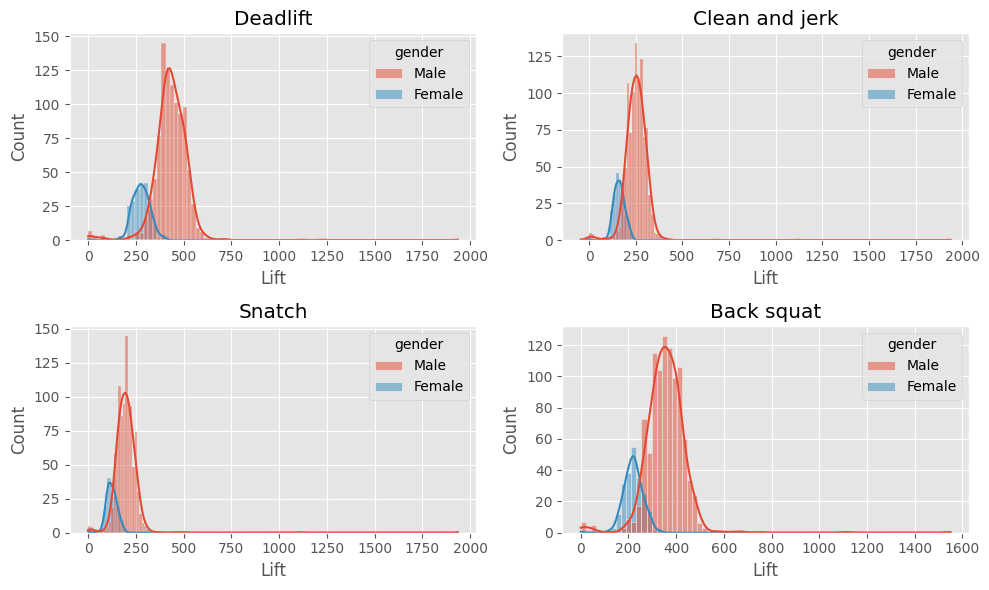

In [98]:
df = df.dropna()
xlabel = 'Lift'
plt.subplot(221)
sns.histplot(data = df, x = 'deadlift', hue='gender',kde = True);
plt.title('Deadlift')
plt.xlabel(xlabel)
plt.subplot(222)
sns.histplot(data = df, x = 'candj', hue='gender',kde = True);
plt.title('Clean and jerk')
plt.xlabel(xlabel)
plt.tight_layout()
plt.subplot(223)
sns.histplot(data = df, x = 'snatch', hue='gender',kde = True);
plt.title('Snatch')
plt.xlabel(xlabel)
plt.subplot(224)
sns.histplot(data = df, x = 'backsq', hue='gender',kde = True);
plt.title('Back squat')
plt.xlabel(xlabel)
plt.tight_layout()

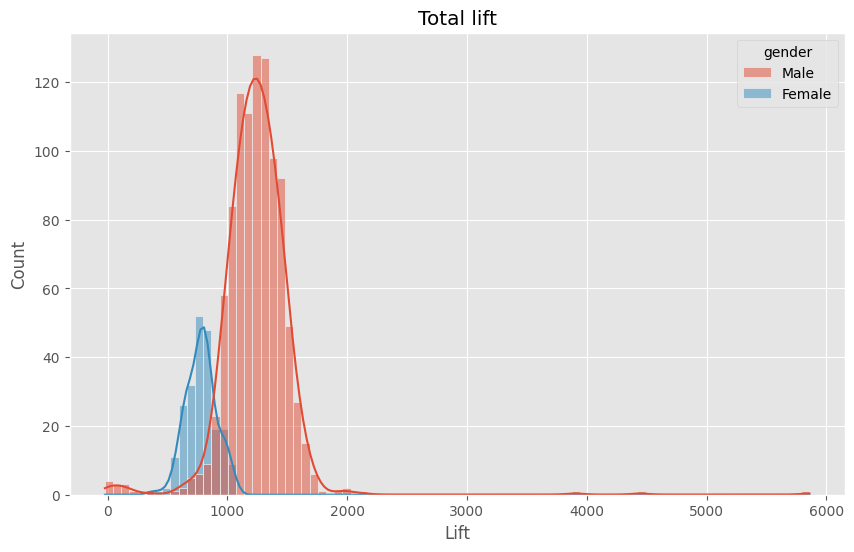

In [99]:
#total lift
sns.histplot(data = df, x = 'total_lift', hue='gender',kde = True);
plt.title('Total lift')
plt.xlabel(xlabel);

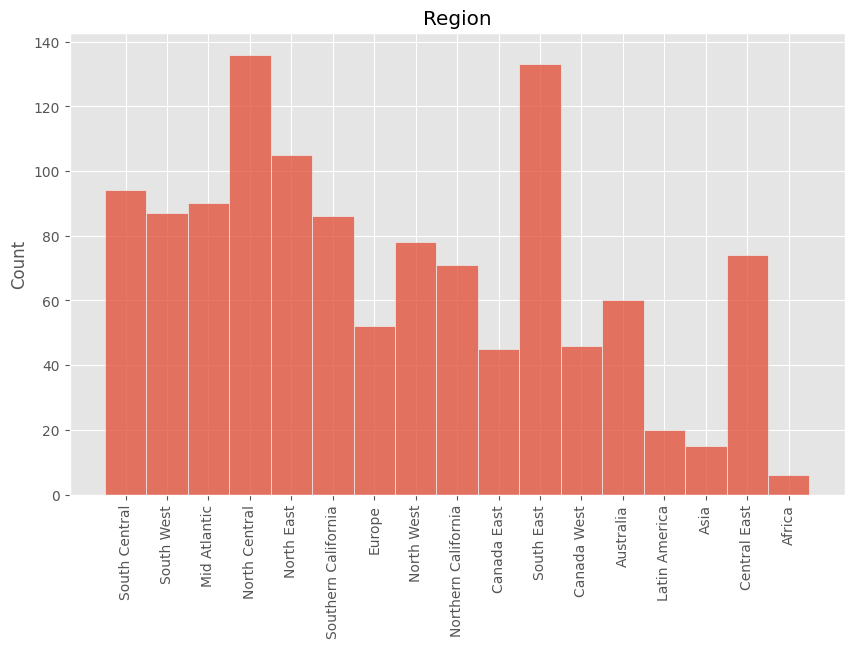

In [100]:
#plt.subplot(1,2,1)
plt.title('Region')
sns.histplot(data = df, x = 'region')
plt.xlabel('')
plt.xticks(rotation = 90)

#plt.subplot(1,2,2)
#plt.title('Country')
#plt.bar('US',US.sum())
#plt.bar('non-US',(df.shape[0]-df['US'].sum()))

#plt.tight_layout()
plt.show()

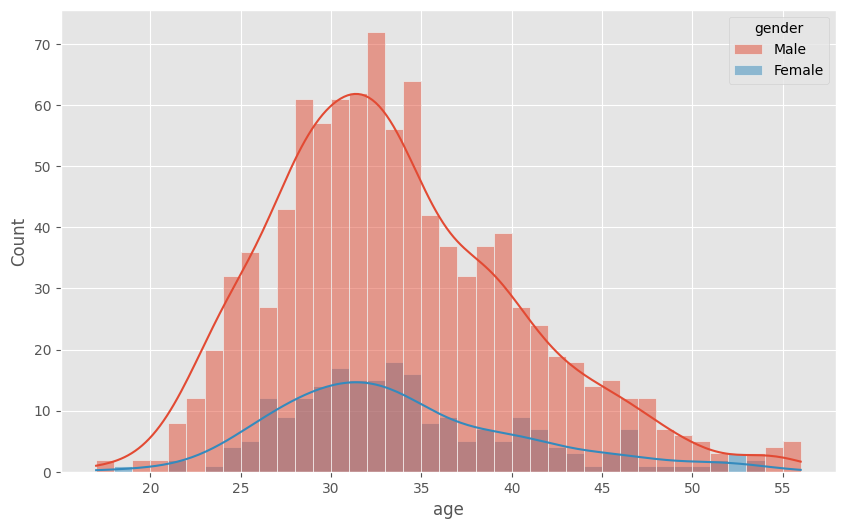

In [101]:
sns.histplot(data = df, x = 'age', hue='gender',binwidth=1,kde = True)
plt.show()


<ipython-input-102-8afaafe5de96>:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


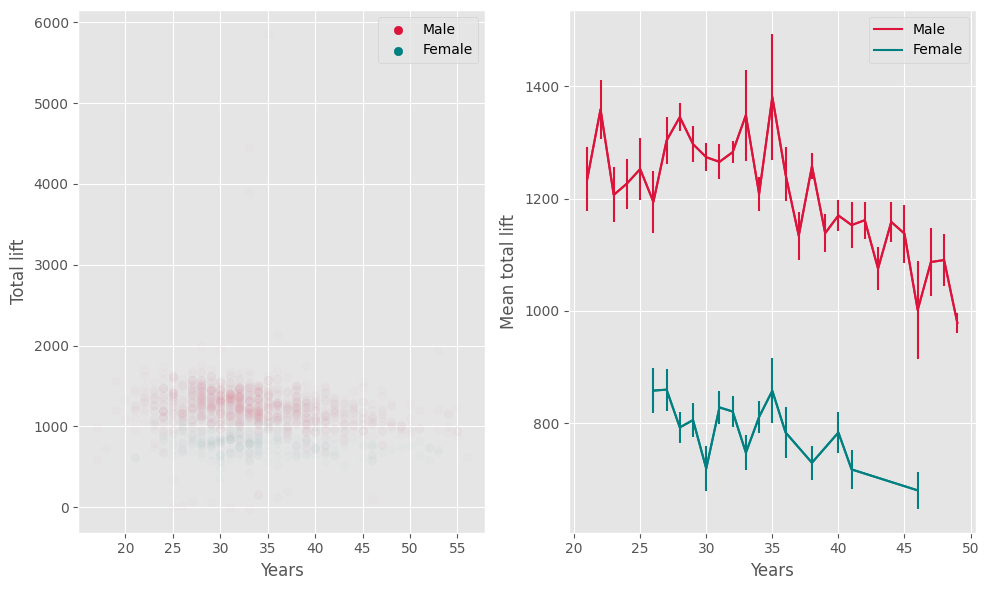

In [102]:
import numpy as np
def standard_error(x):
    stdev = x.std()
    counts = x.count()
    return stdev/np.sqrt(counts)

df_age = df[['age','gender','total_lift']].groupby(['age','gender']).agg(['mean',standard_error,'size']).sort_values('age').reset_index()
df_age_f = df_age[(df_age['gender']=='Female')&(df_age['total_lift']['size']>5)]
df_age_m = df_age[(df_age['gender']=='Male')&(df_age['total_lift']['size']>5)]

plt.subplot(1,2,1)
plt.scatter(df.age[df.gender=='Male'], df.total_lift[df.gender=='Male'],alpha=0.01,color='crimson',label='Male')
plt.scatter(df.age[df.gender=='Female'], df.total_lift[df.gender=='Female'],alpha=0.01,color='teal',label='Female')
plt.xlabel('Years')
plt.ylabel('Total lift')
leg = plt.legend()
for lh in leg.legendHandles:
    lh.set_alpha(1)

plt.subplot(1,2,2)
sns.lineplot(x=df_age_m['age'],y=df_age_m['total_lift']['mean'],color='crimson',label='Male')
plt.errorbar(df_age_m.age,df_age_m['total_lift']['mean'],yerr=df_age_m['total_lift']['standard_error'],color='crimson',label='_Male_')
sns.lineplot(x=df_age_f['age'],y=df_age_f['total_lift']['mean'],color='teal', label='Female')
plt.errorbar(df_age_f.age,df_age_f['total_lift']['mean'],yerr=df_age_f['total_lift']['standard_error'],color='teal',label='_Female_')
plt.legend()
plt.xlabel('Years')
plt.ylabel('Mean total lift')

plt.tight_layout()

<ipython-input-103-99d29c66f2cb>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  vmin = df.corr().min().min()
<ipython-input-103-99d29c66f2cb>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  vmax = df.corr()[df.corr()!=1].max().max()
<ipython-input-103-99d29c66f2cb>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr  = df.drop(columns=['athlete_id','name','region','team','affiliate','gender','eat','train','background','experience','schedule','howlong']).corr()[np.absol

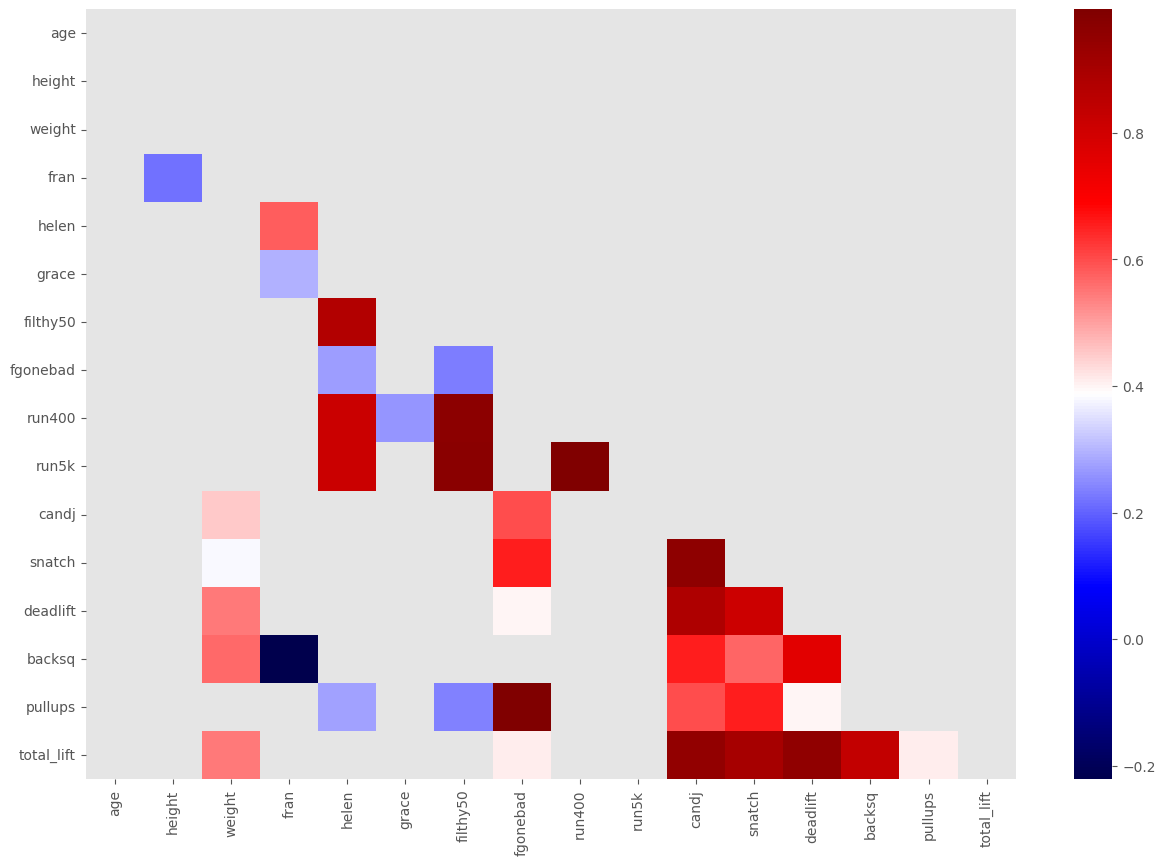

In [103]:
#Heat map

#optimizng range for color scale
vmin = df.corr().min().min()
vmax = df.corr()[df.corr()!=1].max().max()

#thresholding selected correlations
#df_corr  = df.drop(columns=['backsq','deadlift','candj','snatch','exp_start_nr','sched_nr','rest_nr']).corr()[np.absolute(df.corr())>0.2]
df_corr  = df.drop(columns=['athlete_id','name','region','team','affiliate','gender','eat','train','background','experience','schedule','howlong']).corr()[np.absolute(df.corr())>0.2]

#Mask for selecting only bottom triangle
mask = np.triu(df_corr)

plt.figure(figsize=(15,10))
#plt.style.context('default')
sns.heatmap(df_corr,vmin=vmin, vmax=vmax,mask=mask,cmap='seismic')
plt.grid()
#print(mask)

### Predicting total fit with data version 01

In [109]:
df = df_v01_pandas.copy()
df = df.dropna(subset=['region','age','weight','height','howlong','gender','eat','train','background','experience','schedule','howlong','deadlift','candj','snatch','backsq','experience','background','schedule','howlong']) #removing NaNs from parameters of interest
df = df.drop(columns=['affiliate','team','name','athlete_id','fran','helen','grace','filthy50','fgonebad','run400','run5k','pullups','train']) #removing paramters not of interest + less popular events

In [102]:
import tensorflow as tf
from keras.layers import Dropout, BatchNormalization
from functools import partial
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32172 entries, 6 to 422961
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      32172 non-null  object 
 1   gender      32172 non-null  object 
 2   age         32172 non-null  float64
 3   height      32172 non-null  float64
 4   weight      32172 non-null  float64
 5   candj       32172 non-null  float64
 6   snatch      32172 non-null  float64
 7   deadlift    32172 non-null  float64
 8   backsq      32172 non-null  float64
 9   eat         32172 non-null  object 
 10  background  32172 non-null  object 
 11  experience  32172 non-null  object 
 12  schedule    32172 non-null  object 
 13  howlong     32172 non-null  object 
 14  total_lift  32172 non-null  float64
dtypes: float64(8), object(7)
memory usage: 3.9+ MB


In [114]:
df_select = df.drop(columns=['region','gender','eat','background','experience','schedule','howlong'])
print('Selected features:\n',df_select.columns.values)
train_set, test_set = train_test_split(df_select, test_size=0.2, random_state=10)
X_train, y_train = train_set.drop(columns=['total_lift']), train_set['total_lift']

Selected features:
 ['age' 'height' 'weight' 'candj' 'snatch' 'deadlift' 'backsq' 'total_lift']


In [116]:
#splitting test data to make a validation dataset
valid_set_nn, test_set_nn = train_test_split(test_set, test_size=0.5, random_state=10)
X_valid_nn = valid_set_nn.drop(columns=['total_lift'])
y_valid_nn = valid_set_nn['total_lift'].values.reshape(-1,1)
X_test_nn = test_set_nn.drop(columns=['total_lift'])
y_test_nn = test_set_nn['total_lift']

In [117]:
#building neural network
tf.random.set_seed(10)

layer_size = 300
RegularizedDense = partial(tf.keras.layers.Dense,
                           activation = 'relu',
                           kernel_initializer='he_normal')
                           #kernel_regularizer = tf.keras.regularizers.l2(0.001))

model = tf.keras.Sequential([
    tf.keras.Input(shape=[X_train.shape[1]]),
    BatchNormalization(name = 'Batch_Normalization'),
    RegularizedDense(layer_size, name = "Dense_1"),
    Dropout(0.3, name = 'Dropout_1'),
    RegularizedDense(layer_size, name = "Dense_2"),
    Dropout(0.3, name= 'Dropout_2'),
    tf.keras.layers.Dense(1, activation='relu', name = 'Dense_3')
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=30,
    decay_rate=0.99)

opt = tf.keras.optimizers.experimental.Adam(learning_rate=lr_schedule)

model.compile(loss='mse',
              optimizer = opt,
              metrics=['RootMeanSquaredError']
             )

model.training=True
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Batch_Normalization (BatchN  (None, 7)                28        
 ormalization)                                                   
                                                                 
 Dense_1 (Dense)             (None, 300)               2400      
                                                                 
 Dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 Dense_2 (Dense)             (None, 300)               90300     
                                                                 
 Dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 Dense_3 (Dense)             (None, 1)                 301       
                                                      

In [119]:
history = model.fit(X_train, y_train, epochs=30, verbose=False, validation_data=(X_valid_nn, y_valid_nn))

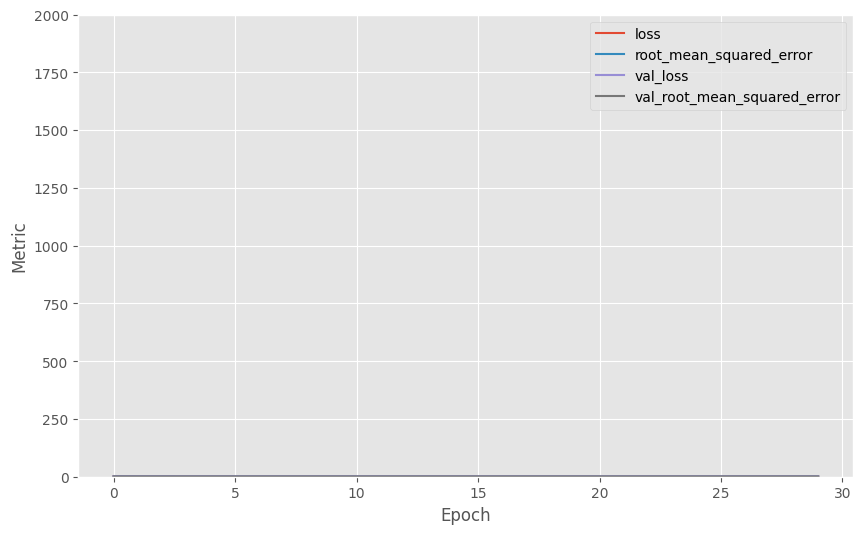

In [162]:
pd.DataFrame(history.history).plot(xlabel='Epoch',ylim=[0,2000],ylabel='Metric');

In [121]:
model.training=False
y_pred_nn = model.predict(X_test_nn, verbose=False)
nn_rmse = mean_squared_error(y_test_nn, y_pred_nn,squared=False)
print('Neural network RMSE:')
round(nn_rmse,3)

Neural network RMSE:


1167.388

### EDA for data version 02

In [17]:
df = df_v02_pandas.copy()

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
plt.style.use('ggplot')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

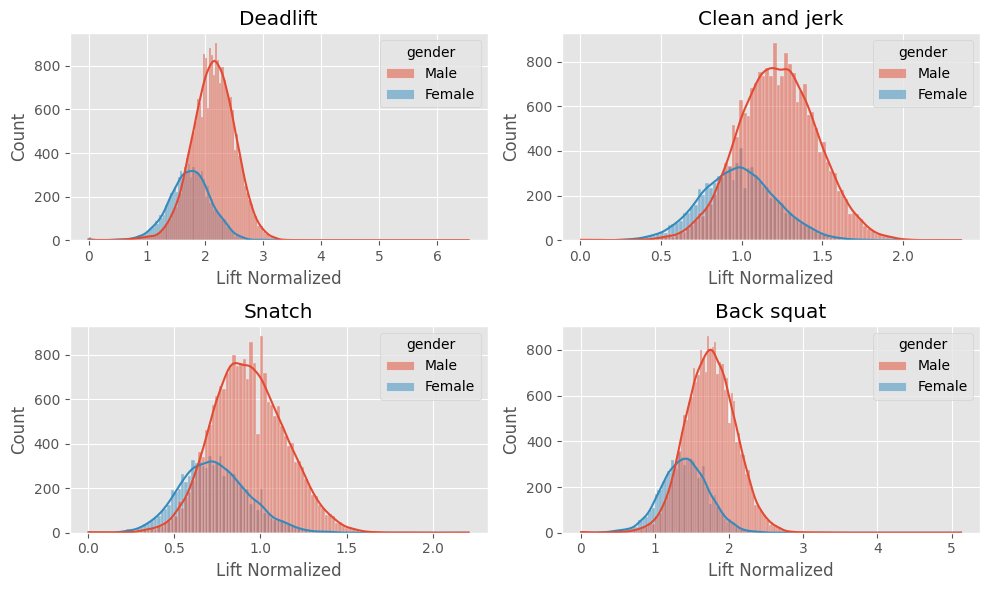

In [20]:
df = df.dropna()
xlabel = 'Lift Normalized'
plt.subplot(221)
sns.histplot(data = df, x = 'norm_dl', hue='gender',kde = True);
plt.title('Deadlift')
plt.xlabel(xlabel)
plt.subplot(222)
sns.histplot(data = df, x = 'norm_j', hue='gender',kde = True);
plt.title('Clean and jerk')
plt.xlabel(xlabel)
plt.tight_layout()
plt.subplot(223)
sns.histplot(data = df, x = 'norm_s', hue='gender',kde = True);
plt.title('Snatch')
plt.xlabel(xlabel)
plt.subplot(224)
sns.histplot(data = df, x = 'norm_bs', hue='gender',kde = True);
plt.title('Back squat')
plt.xlabel(xlabel)
plt.tight_layout()

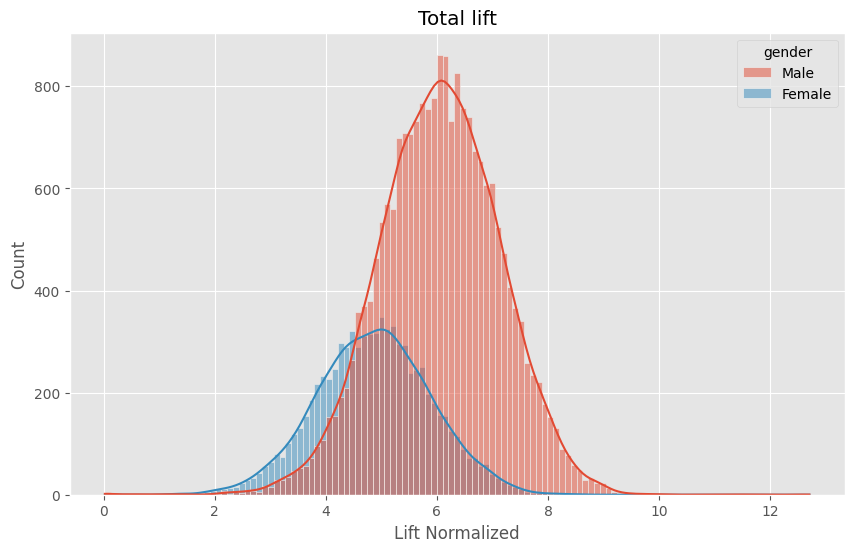

In [21]:
#total lift
sns.histplot(data = df, x = 'total_lift', hue='gender',kde = True);
plt.title('Total lift')
plt.xlabel(xlabel);

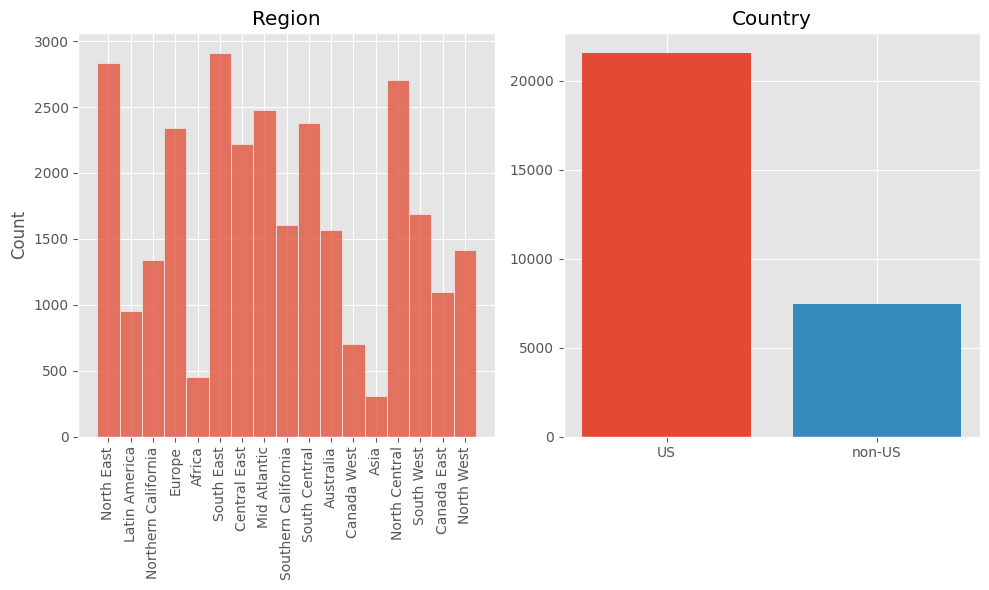

In [22]:
plt.subplot(1,2,1)
plt.title('Region')
sns.histplot(data = df, x = 'region')
plt.xlabel('')
plt.xticks(rotation = 90)

plt.subplot(1,2,2)
plt.title('Country')
plt.bar('US',df['US'].sum())
plt.bar('non-US',(df.shape[0]-df['US'].sum()))

plt.tight_layout()
plt.show()

In [23]:
#Mean BMI
import numpy as np
def standard_error(x):
   stdev = x.std()
   counts = x.count()
   return stdev/np.sqrt(counts)

df['bmi_rounded'] =  df['BMI'].round()
df_bmi = df[['bmi_rounded','total_lift','gender']].groupby(['bmi_rounded','gender']).agg(['mean',standard_error,'size']).sort_values('bmi_rounded').reset_index()
df_bmi_f = df_bmi[(df_bmi['gender']=='Female')&(df_bmi['total_lift']['size']>5)]
df_bmi_m = df_bmi[(df_bmi['gender']=='Male')&(df_bmi['total_lift']['size']>5)]

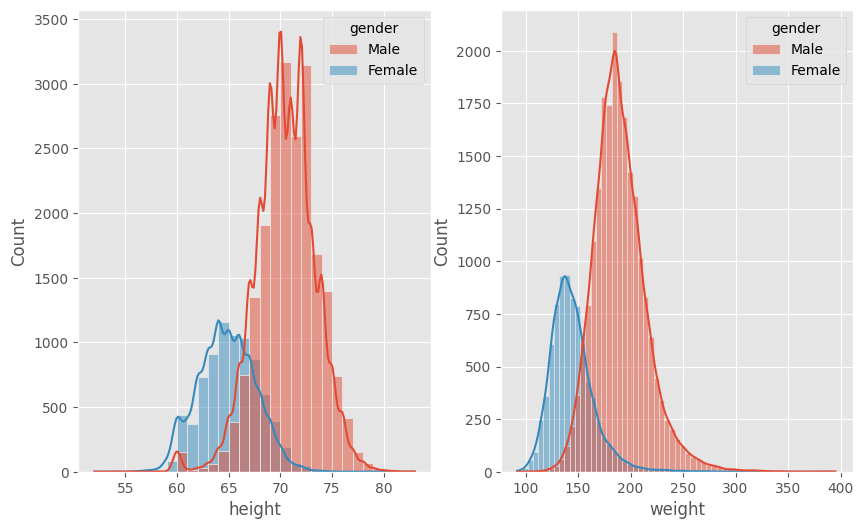

In [24]:
plt.subplot(1,2,1)
sns.histplot(data=df, x='height', hue='gender', binwidth=1,kde=True)
plt.subplot(1,2,2)
sns.histplot(data=df, x='weight', hue='gender', binwidth=5, kde=True)
plt.show()

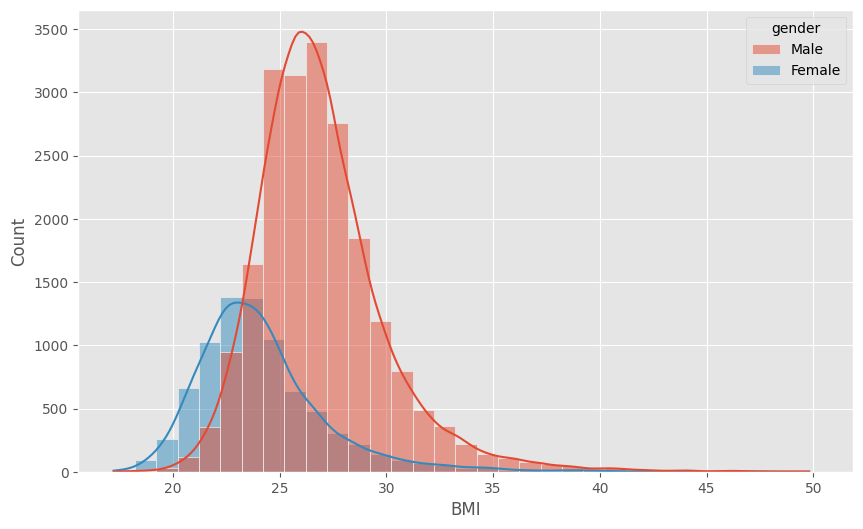

In [25]:
sns.histplot(data = df, x='BMI',hue='gender',binwidth=1,kde=True)
plt.show()

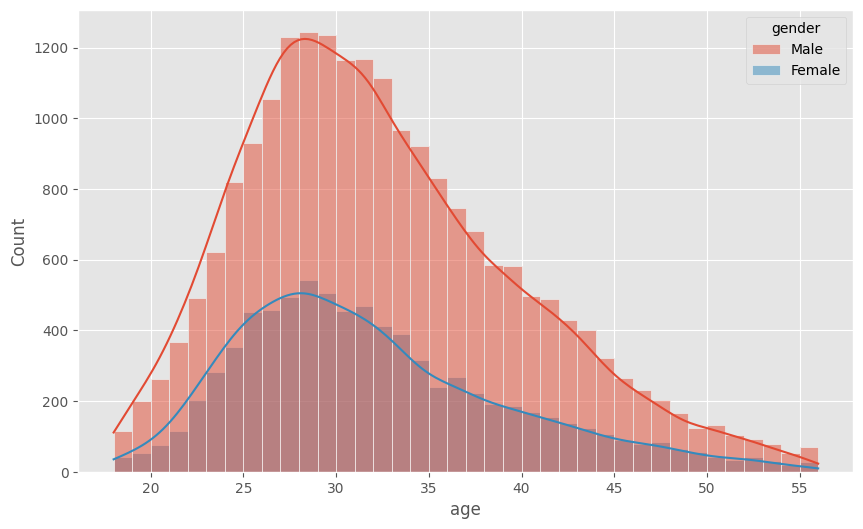

In [26]:
sns.histplot(data = df, x = 'age', hue='gender',binwidth=1,kde = True)
plt.show()


<ipython-input-27-8afaafe5de96>:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


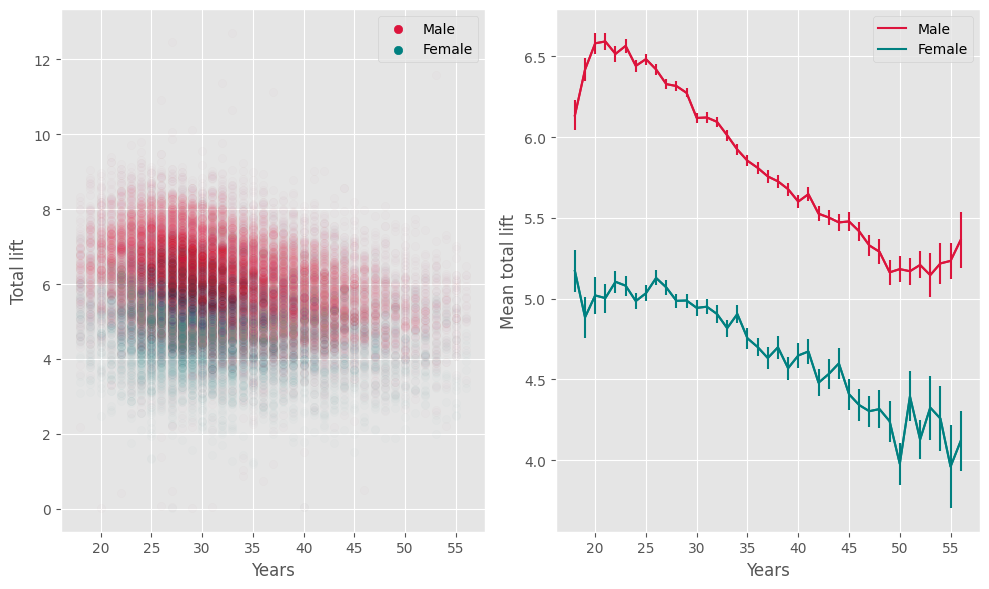

In [27]:
import numpy as np
def standard_error(x):
    stdev = x.std()
    counts = x.count()
    return stdev/np.sqrt(counts)

df_age = df[['age','gender','total_lift']].groupby(['age','gender']).agg(['mean',standard_error,'size']).sort_values('age').reset_index()
df_age_f = df_age[(df_age['gender']=='Female')&(df_age['total_lift']['size']>5)]
df_age_m = df_age[(df_age['gender']=='Male')&(df_age['total_lift']['size']>5)]

plt.subplot(1,2,1)
plt.scatter(df.age[df.gender=='Male'], df.total_lift[df.gender=='Male'],alpha=0.01,color='crimson',label='Male')
plt.scatter(df.age[df.gender=='Female'], df.total_lift[df.gender=='Female'],alpha=0.01,color='teal',label='Female')
plt.xlabel('Years')
plt.ylabel('Total lift')
leg = plt.legend()
for lh in leg.legendHandles:
    lh.set_alpha(1)

plt.subplot(1,2,2)
sns.lineplot(x=df_age_m['age'],y=df_age_m['total_lift']['mean'],color='crimson',label='Male')
plt.errorbar(df_age_m.age,df_age_m['total_lift']['mean'],yerr=df_age_m['total_lift']['standard_error'],color='crimson',label='_Male_')
sns.lineplot(x=df_age_f['age'],y=df_age_f['total_lift']['mean'],color='teal', label='Female')
plt.errorbar(df_age_f.age,df_age_f['total_lift']['mean'],yerr=df_age_f['total_lift']['standard_error'],color='teal',label='_Female_')
plt.legend()
plt.xlabel('Years')
plt.ylabel('Mean total lift')

plt.tight_layout()

<ipython-input-28-9312523fd351>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,1)


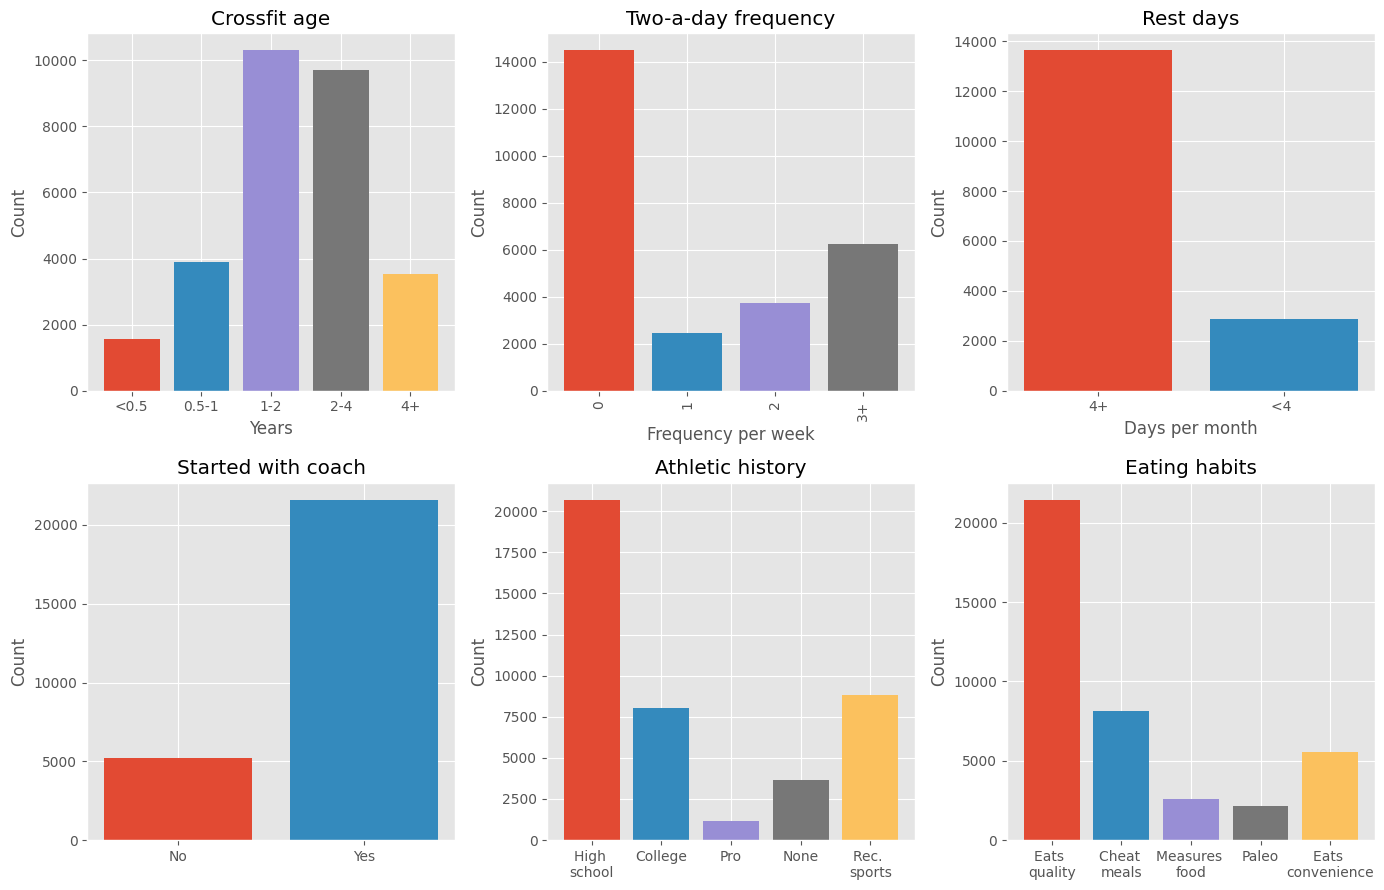

In [28]:
plt.figure(figsize=(14,9))
plt.title('Lifestyle Survey Responses')
plt.subplot(2,3,1)
plt.bar('<0.5',df['exp_lt6mo'].sum())
plt.bar('0.5-1',df['exp_6to12mo'].sum())
plt.bar('1-2',df['exp_1to2yrs'].sum())
plt.bar('2-4',df['exp_2to4yrs'].sum())
plt.bar('4+',df['exp_4plus'].sum())
plt.title('Crossfit age');
plt.ylabel('Count')
plt.xlabel('Years')

plt.subplot(2,3,2)
plt.bar('0', df['sched_0extra'].sum())
plt.bar('1', df['sched_1extra'].sum())
plt.bar('2', df['sched_2extra'].sum())
plt.bar('3+', df['sched_3extra'].sum())
plt.title('Two-a-day frequency')
plt.ylabel('Count')
plt.xlabel('Frequency per week')
plt.xticks(rotation = 90);

plt.subplot(2,3,3)
#plt.bar('Scheduled', df['rest_sched'].sum())
plt.bar('4+', df['rest_plus'].sum())
plt.bar('<4 ', df['rest_minus'].sum())
plt.title('Rest days')
plt.xlabel('Days per month')
plt.ylabel('Count')

plt.subplot(2,3,4)
plt.title('Started with coach')
plt.bar('No', df['exp_alone'].sum()-df['exp_start_nr'].sum())
plt.bar('Yes', df['exp_coach'].sum())
plt.ylabel('Count')
#plt.bar('Crossfit trainer', df['trainer'].sum())
#plt.bar('Completed specialty course', df['specialty_course'].sum())
#plt.bar('Completed level 1', df['level_one'].sum())
#plt.xticks(rotation=90);

plt.subplot(2,3,5)
plt.bar('High \nschool', df['high_school'].sum())
plt.bar('College', df['college'].sum())
plt.bar('Pro', df['pro'].sum())
plt.bar('None', df['no_background'].sum())
plt.bar('Rec. \nsports', df['rec'].sum())
plt.ylabel('Count')
#plt.xlabel('Background')
plt.title('Athletic history')
#plt.xticks(rotation=90)

plt.subplot(2,3,6)
plt.bar('Eats \nquality', df['eat_quality'].sum())
plt.bar('Cheat \nmeals', df['eat_cheat'].sum())
plt.bar('Measures \nfood', df['eat_weigh'].sum())
plt.bar('Paleo', df['eat_paleo'].sum())
plt.bar('Eats \nconvenience', df['eat_conv'].sum())
plt.ylabel('Count')
plt.title('Eating habits')
#plt.xticks(rotation=90)

plt.tight_layout()

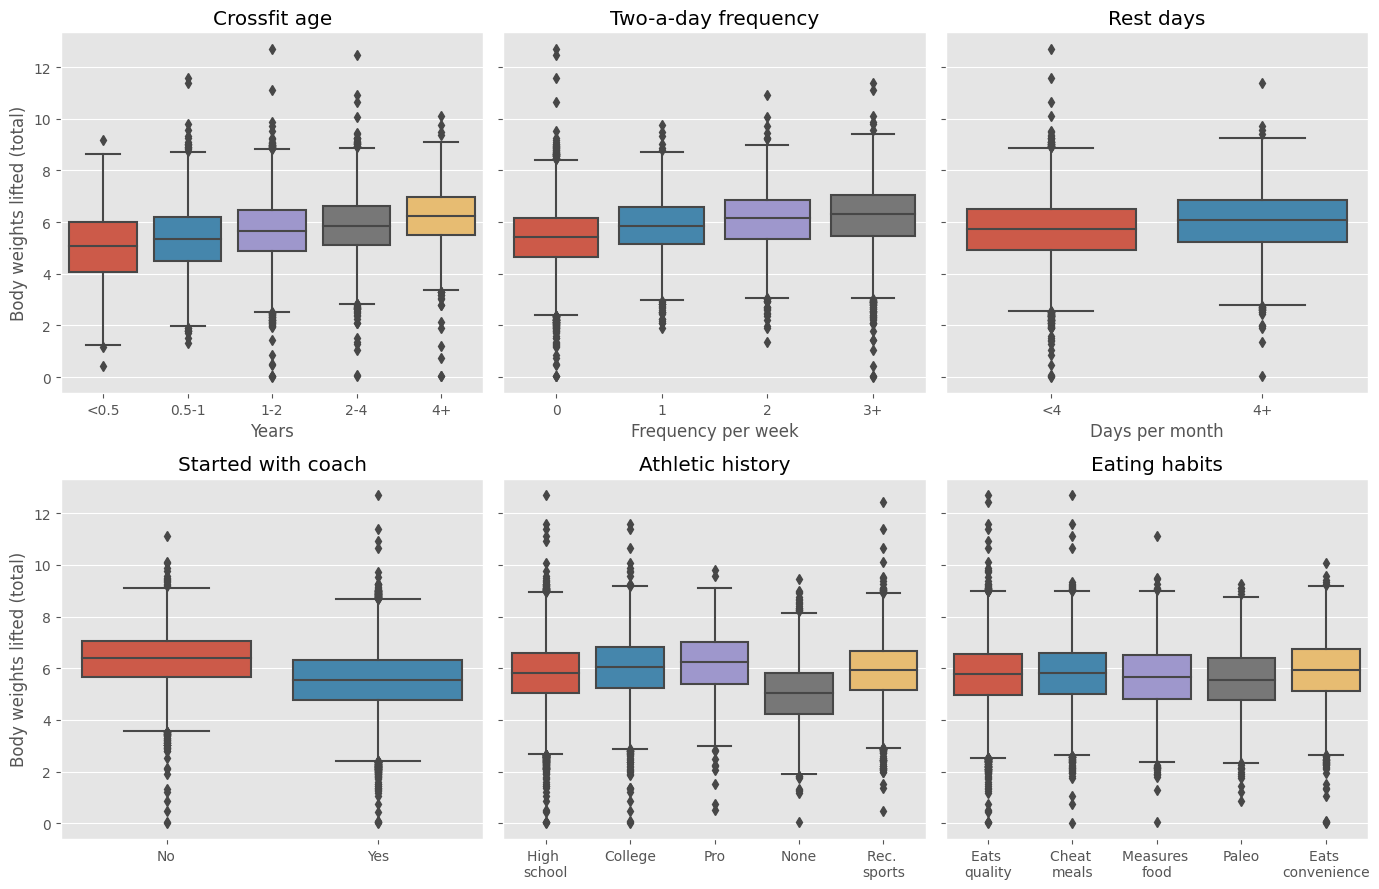

In [29]:
import pandas as pd

#melting data for boxplots
df_exp =  pd.melt(df, id_vars=['total_lift'], var_name='experience', value_vars=['exp_lt6mo','exp_6to12mo','exp_1to2yrs','exp_2to4yrs','exp_4plus','total_lift'])
df_exp = df_exp[df_exp!=0].dropna()
df_freq = pd.melt(df, id_vars=['total_lift'], var_name='freq', value_vars=['sched_0extra','sched_1extra','sched_2extra','sched_3extra'])
df_freq = df_freq[df_freq!=0].dropna()
df_rest = pd.melt(df, id_vars=['total_lift'], var_name='rest', value_vars=['rest_plus', 'rest_minus'])
df_rest = df_rest[df_rest!=0].dropna()
df_hist = pd.melt(df, id_vars=['total_lift'], var_name='hist', value_vars=['high_school','college','pro','no_background','rec'])
df_hist = df_hist[df_hist!=0].dropna()
df_start = pd.melt(df, id_vars=['total_lift'], var_name='start', value_vars=['exp_alone','exp_coach'])
df_start = df_start[df_start!=0].dropna()
df_eat = pd.melt(df, id_vars=['total_lift'], var_name='eat', value_vars=['eat_quality','eat_cheat','eat_weigh','eat_paleo','eat_conv'])
df_eat = df_eat[df_eat!=0].dropna()

y_label = 'Body weights lifted (total)'

#box plots of above figures
fig, axs = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(14,9))

for ax in axs.flatten()[1:]:
    ax.yaxis.label.set_visible(False)
    #ax.yaxis.set_ticks([])

ax1 = plt.subplot(2,3,1)
sns.boxplot(data = df_exp, x='experience',y='total_lift')
ax1.set_xticklabels(('<0.5','0.5-1','1-2','2-4','4+'))
ax1.set_xlabel('Years')
ax1.set_ylabel(y_label)
ax1.set_title('Crossfit age')
ax2 = plt.subplot(2,3,2)
sns.boxplot(data=df_freq, x='freq',y='total_lift')
ax2.set_xticklabels(('0','1','2','3+'))
ax2.set_xlabel('Frequency per week')
ax2.set_title('Two-a-day frequency')
ax3 = plt.subplot(2,3,3)
sns.boxplot(data=df_rest, x='rest',y='total_lift')
ax3.set_xticklabels(('<4','4+'))
ax3.set_title('Rest days')
ax3.set_xlabel('Days per month')
ax4 = plt.subplot(2,3,4)
sns.boxplot(data=df_start,x='start',y='total_lift')
ax4.set_xticklabels(('No','Yes'))
ax4.set_xlabel('')
ax4.set_title('Started with coach')
ax4.yaxis.label.set_visible(True)
ax4.set_ylabel(y_label)
ax5 = plt.subplot(2,3,5)
sns.boxplot(data=df_hist, x='hist',y='total_lift')
ax5.set_xticklabels(('High \nschool','College','Pro','None','Rec. \nsports'))
ax5.set_xlabel('')
ax5.set_title('Athletic history')
ax6 = plt.subplot(2,3,6)
sns.boxplot(data=df_eat, x='eat',y='total_lift')
ax6.set_xticklabels(('Eats \nquality','Cheat \nmeals','Measures \nfood','Paleo','Eats \nconvenience'))
ax6.set_xlabel('')
ax6.set_title('Eating habits')
plt.tight_layout()

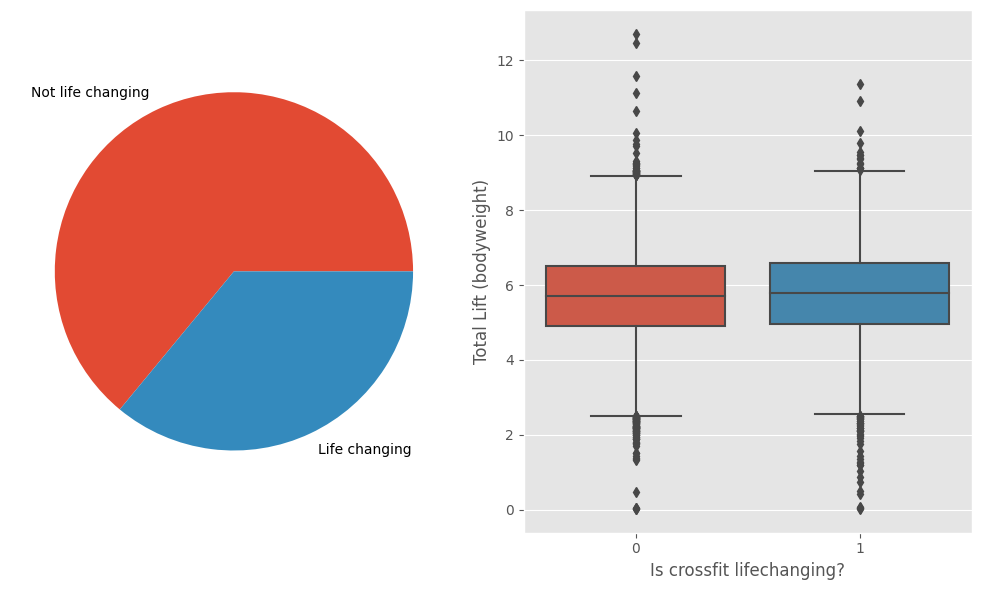

In [30]:
changed = df['life_changing'].sum()
not_changed = df.shape[0]-changed #non-answers are considered non-life changing responses

plt.subplot(1,2,1)
plt.pie([not_changed, changed],labels=['Not life changing','Life changing'])

plt.subplot(1,2,2)
sns.boxplot(x = df.life_changing, y=df.total_lift)
plt.ylabel('Total Lift (bodyweight)')
plt.xlabel('Is crossfit lifechanging?')
plt.tight_layout()

<ipython-input-31-b5e1a0a0405f>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  vmin = df.corr().min().min()
<ipython-input-31-b5e1a0a0405f>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  vmax = df.corr()[df.corr()!=1].max().max()
<ipython-input-31-b5e1a0a0405f>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr  = df.drop(columns=['backsq','deadlift','candj','snatch','exp_start_nr','sched_nr','rest_nr']).corr()[np.absolute(df.corr())>0.2]


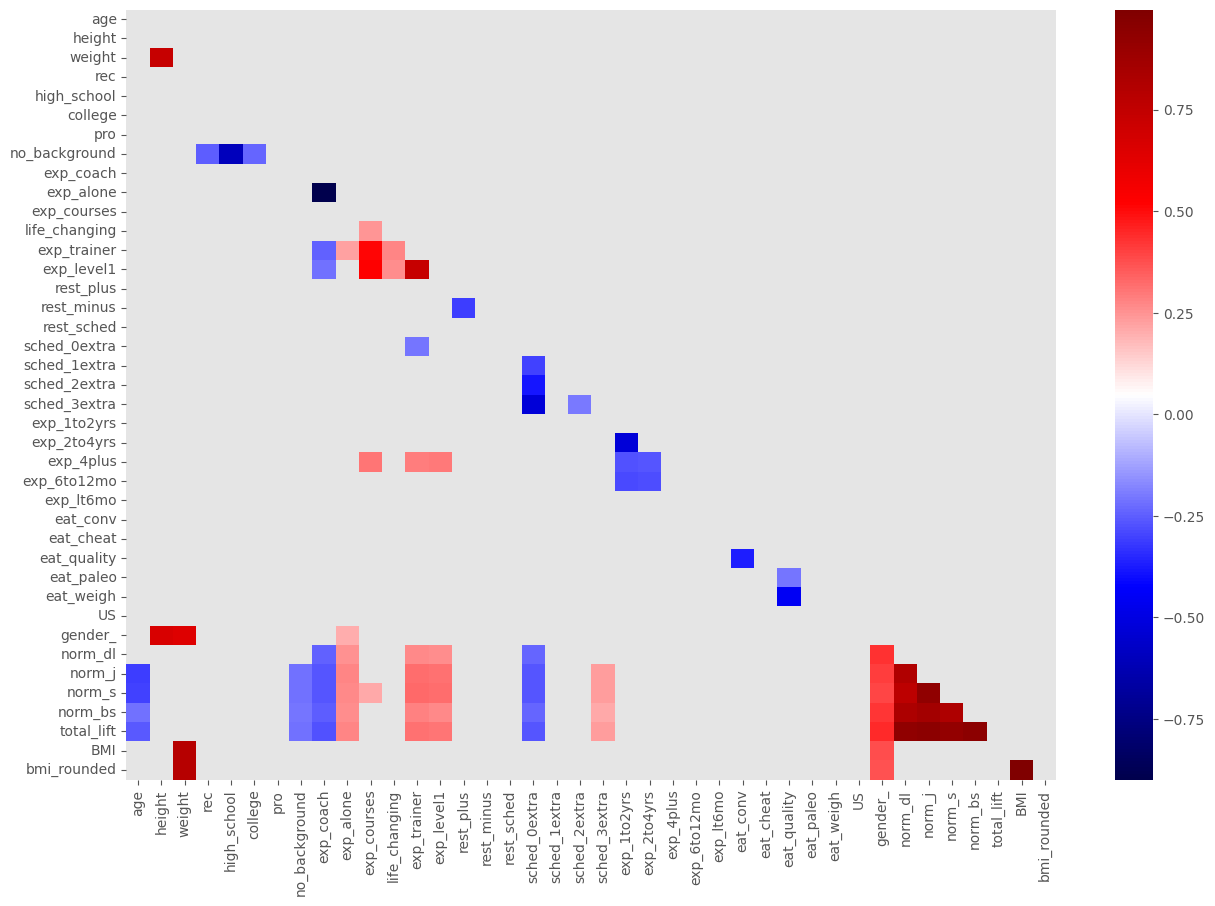

In [31]:
#Heat map

#optimizng range for color scale
vmin = df.corr().min().min()
vmax = df.corr()[df.corr()!=1].max().max()

#thresholding selected correlations
df_corr  = df.drop(columns=['backsq','deadlift','candj','snatch','exp_start_nr','sched_nr','rest_nr']).corr()[np.absolute(df.corr())>0.2]
#df_corr  = df.drop(columns=['athlete_id','name','region','team','affiliate','gender','eat','train','background','experience','schedule','howlong']).corr()[np.absolute(df.corr())>0.2]

#Mask for selecting only bottom triangle
mask = np.triu(df_corr)

plt.figure(figsize=(15,10))
#plt.style.context('default')
sns.heatmap(df_corr,vmin=vmin, vmax=vmax,mask=mask,cmap='seismic')
plt.grid()
#print(mask)

### Predicting total fit with data version 02

In [32]:
import tensorflow as tf
from keras.layers import Dropout, BatchNormalization
from functools import partial
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error

In [33]:
df_select = df.drop(columns=['region','height','weight','candj','snatch','deadlift','norm_bs', 'norm_dl', 'norm_j', 'norm_s','bmi_rounded','backsq','eat','background','experience','schedule','howlong','gender'])
print('Selected features:\n',df_select.columns.values)
train_set, test_set = train_test_split(df_select, test_size=0.2, random_state=10)
X_train, y_train = train_set.drop(columns=['total_lift']), train_set['total_lift']

Selected features:
 ['age' 'rec' 'high_school' 'college' 'pro' 'no_background' 'exp_coach'
 'exp_alone' 'exp_courses' 'life_changing' 'exp_trainer' 'exp_level1'
 'exp_start_nr' 'rest_plus' 'rest_minus' 'rest_sched' 'sched_0extra'
 'sched_1extra' 'sched_2extra' 'sched_3extra' 'sched_nr' 'rest_nr'
 'exp_1to2yrs' 'exp_2to4yrs' 'exp_4plus' 'exp_6to12mo' 'exp_lt6mo'
 'eat_conv' 'eat_cheat' 'eat_quality' 'eat_paleo' 'eat_weigh' 'US'
 'gender_' 'total_lift' 'BMI']


In [169]:
#splitting test data to make a validation dataset
valid_set_nn, test_set_nn = train_test_split(test_set, test_size=0.5, random_state=10)
X_valid_nn = valid_set_nn.drop(columns=['total_lift'])
y_valid_nn = valid_set_nn['total_lift'].values.reshape(-1,1)
X_test_nn = test_set_nn.drop(columns=['total_lift'])
y_test_nn = test_set_nn['total_lift']

In [170]:
#building neural network
tf.random.set_seed(10)

layer_size = 300
RegularizedDense = partial(tf.keras.layers.Dense,
                           activation = 'relu',
                           kernel_initializer='he_normal')
                           #kernel_regularizer = tf.keras.regularizers.l2(0.001))

model = tf.keras.Sequential([
    tf.keras.Input(shape=[X_train.shape[1]]),
    BatchNormalization(name = 'Batch_Normalization'),
    RegularizedDense(layer_size, name = "Dense_1"),
    Dropout(0.3, name = 'Dropout_1'),
    RegularizedDense(layer_size, name = "Dense_2"),
    Dropout(0.3, name= 'Dropout_2'),
    tf.keras.layers.Dense(1, activation='relu', name = 'Dense_3')
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=30,
    decay_rate=0.99)

opt = tf.keras.optimizers.experimental.Adam(learning_rate=lr_schedule)

model.compile(loss='mse',
              optimizer = opt,
              metrics=['RootMeanSquaredError']
             )

model.training=True
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Batch_Normalization (BatchN  (None, 35)               140       
 ormalization)                                                   
                                                                 
 Dense_1 (Dense)             (None, 300)               10800     
                                                                 
 Dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 Dense_2 (Dense)             (None, 300)               90300     
                                                                 
 Dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 Dense_3 (Dense)             (None, 1)                 301       
                                                     

In [171]:
history = model.fit(X_train, y_train, epochs=30, verbose=False, validation_data=(X_valid_nn, y_valid_nn))

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


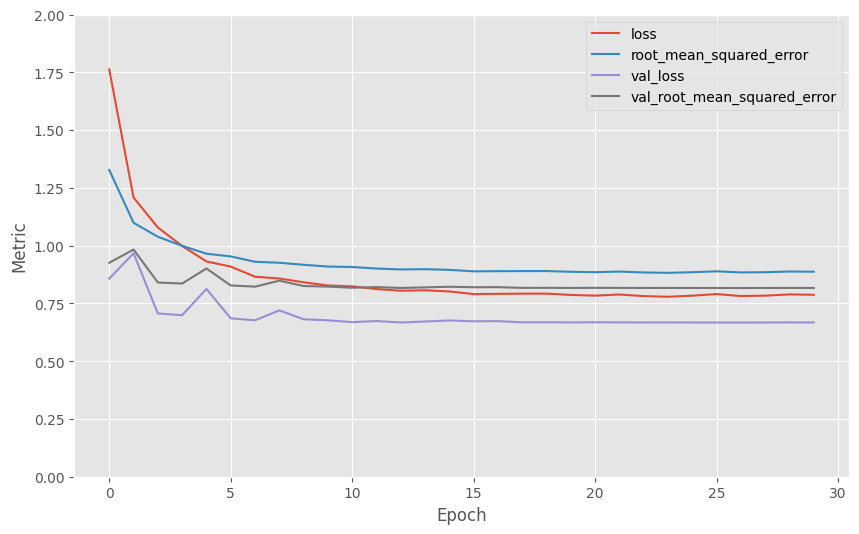

In [172]:
pd.DataFrame(history.history).plot(xlabel='Epoch',ylim=[0,2],ylabel='Metric');

In [173]:
model.training=False
y_pred_nn = model.predict(X_test_nn, verbose=False)
nn_rmse = mean_squared_error(y_test_nn, y_pred_nn,squared=False)
print('Neural network RMSE:')
round(nn_rmse,3)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Neural network RMSE:


0.859

### Compare and comment on the accuracy/metrics of the models using v1 and v2.

- Neural Network model from dataset version 01 has RMSE: 1167.388
- Neural Network model from dataset version 02 has RMSE: 0.859

### Use tensor flow privacy library with the dataset v2 and calculate the metrics for the new DP model.

In [13]:
#!pip install tensorflow-privacy

In [14]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

import numpy as np
tf.get_logger().setLevel('ERROR')

Instructions for updating:
non-resource variables are not supported in the long term


In [15]:
import tensorflow_privacy as tfp
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from sklearn.preprocessing import StandardScaler

In [176]:
#building neural network
tf.random.set_seed(10)

layer_size = 300
RegularizedDense = partial(tf.keras.layers.Dense,
                           activation = 'relu',
                           kernel_initializer='he_normal')
                           #kernel_regularizer = tf.keras.regularizers.l2(0.001))

model = tf.keras.Sequential([
    tf.keras.Input(shape=[X_train.shape[1],]),
    BatchNormalization(name = 'Batch_Normalization'),
    RegularizedDense(layer_size, name = "Dense_1"),
    Dropout(0.3, name = 'Dropout_1'),
    RegularizedDense(layer_size, name = "Dense_2"),
    Dropout(0.3, name= 'Dropout_2'),
    tf.keras.layers.Dense(1, activation='relu', name = 'Dense_3')
])


model.training=True
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Batch_Normalization (BatchN  (None, 35)               140       
 ormalization)                                                   
                                                                 
 Dense_1 (Dense)             (None, 300)               10800     
                                                                 
 Dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 Dense_2 (Dense)             (None, 300)               90300     
                                                                 
 Dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 Dense_3 (Dense)             (None, 1)                 301       
                                                     

In [35]:
epochs = 30
batch_size = 250

In [36]:
l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = 1
learning_rate = 0.25

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

In [179]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=30,
    decay_rate=0.99)

optimizer = tfp.DPKerasAdamOptimizer(
                                      l2_norm_clip=l2_norm_clip,
                                      noise_multiplier=noise_multiplier,
                                      num_microbatches=num_microbatches,
                                      learning_rate=lr_schedule)

loss = tf.keras.losses.mean_squared_error

In [180]:
model.compile(optimizer=optimizer, loss=loss, metrics=['RootMeanSquaredError'])

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    validation_data=(X_valid_nn, y_valid_nn),
                    batch_size=batch_size)

Train on 23196 samples, validate on 2899 samples
Epoch 1/30
23000/23196 [============================>.] - ETA: 0s - loss: 14.0342 - root_mean_squared_error: 3.7462

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


23196/23196 [==============================] - 3s 138us/sample - loss: 13.9795 - root_mean_squared_error: 3.7389 - val_loss: 4.4114 - val_root_mean_squared_error: 2.1003
Epoch 2/30
23196/23196 [==============================] - 1s 53us/sample - loss: 7.0952 - root_mean_squared_error: 2.6637 - val_loss: 5.3334 - val_root_mean_squared_error: 2.3094
Epoch 3/30
23196/23196 [==============================] - 1s 51us/sample - loss: 7.6746 - root_mean_squared_error: 2.7703 - val_loss: 4.6779 - val_root_mean_squared_error: 2.1629
Epoch 4/30
23196/23196 [==============================] - 1s 52us/sample - loss: 8.7765 - root_mean_squared_error: 2.9625 - val_loss: 3.4300 - val_root_mean_squared_error: 1.8520
Epoch 5/30
23196/23196 [==============================] - 1s 50us/sample - loss: 8.8939 - root_mean_squared_error: 2.9823 - val_loss: 3.9154 - val_root_mean_squared_error: 1.9787
Epoch 6/30
23196/23196 [==============================] - 1s 50us/sample - loss: 9.8604 - root_mean_squared_error:

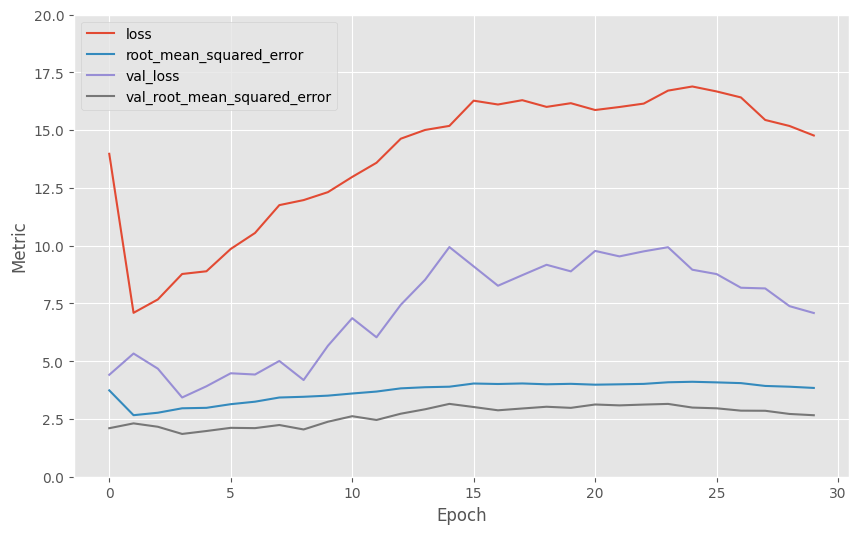

In [182]:
pd.DataFrame(history.history).plot(xlabel='Epoch',ylim=[0,20],ylabel='Metric');

In [183]:
model.training=False
y_pred_nn = model.predict(X_test_nn, verbose=False)
nn_rmse = mean_squared_error(y_test_nn, y_pred_nn,squared=False)
print('Neural network RMSE:')
round(nn_rmse,3)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Neural network RMSE:


2.688

### Compute the DP using TensorFlow privacy compute_dp_sgd_privacy

In [16]:
from tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy_lib import compute_dp_sgd_privacy_statement

In [41]:
privacy_guarantee = compute_dp_sgd_privacy_statement(number_of_examples=X_train.shape[0],
                                              batch_size=batch_size,
                                              noise_multiplier=noise_multiplier,
                                              num_epochs=epochs,
                                              delta=1e-5)

print("Privacy Guarantee Epsilon: \n", privacy_guarantee)

Privacy Guarantee Epsilon: 
 DP-SGD performed over 23196 examples with 250 examples per iteration, noise
multiplier 1.3 for 30 epochs with microbatching, and no bound on number of
examples per user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:        74.229
    Epsilon assuming Poisson sampling (*):                     10.973

No user-level privacy guarantee is possible without a bound on the number of
examples per user.

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed the actual epsilon should be
closer to this value than the conservative assumption of an arbitrary data
order.



In [184]:
tfp.compute_dp_sgd_privacy(n=X_train.shape[0],
                                              batch_size=batch_size,
                                              noise_multiplier=noise_multiplier,
                                              epochs=epochs,
                                              delta=1e-5)

(2.3227197013579666, 9.0)

### Compare and comment on the accuracy/metrics of the non-DP and DP models using dataset v2.

- Neural Network model from dataset version 02 without DP has RMSE: 0.858
- Neural Network model from dataset version 02 with DP has RMSE: 2.688